## Effects of multicollinearity on parameter estimation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
import pandas as pd
import statsmodels.formula.api as smf
from tqdm import tqdm
import seaborn as sns

np.random.seed(123)

def simulate_data(n=500, n_ivs=10, noise=2, high_correlations=True):

    means = np.zeros(n_ivs)
    stds = np.ones(n_ivs) / 3

    cov_idx = np.tril_indices(n_ivs, k=-1)

    n_cells = len(cov_idx[0])
    corrs = np.random.random(n_cells)
    corrs = 1 - (corrs * 2)
    
    if high_correlations:
        # Encourage highly correlated variables
        corrs[np.random.randint(0, n_cells, n_ivs)] = 0.7 + (np.random.random(n_ivs) * 0.2) 
        corrs[np.random.randint(0, n_cells, n_ivs*4)] = 1
        
    else:
        corrs *= 0.2

    covs = np.zeros((n_ivs, n_ivs))

    for i in range(n_cells):
        x, y = cov_idx[0][i], cov_idx[1][i]
        covs[x, y] = stds[x] * stds[y] * corrs[i]
        covs[y, x] = stds[x] * stds[y] * corrs[i]

    np.fill_diagonal(covs, stds ** 2)

    m = np.random.multivariate_normal(means, covs, n, check_valid='ignore').T

    diff = np.abs(np.corrcoef(m) - squareform(corrs))
    mean_diff = np.tril(diff, k=-1).mean()
    
    actual_corr = np.corrcoef(m)
    max_corr = np.abs(actual_corr[np.tril_indices_from(actual_corr, k=-1)]).max()
    mean_corr = np.abs(actual_corr[np.tril_indices_from(actual_corr, k=-1)]).mean()
    betas = 1 - (np.random.random(n_ivs) * 2)[:, None]
    y = (m * betas).sum(axis=0) + np.random.random(n) * noise

    df = pd.DataFrame(np.vstack([m, y[None, :]]).T, columns=['x{0}'.format(i) for i in range(n_ivs)] + ['y'])
    df.head()
    
    return df, betas, max_corr, mean_corr

## Small dataset

This generates a dataset with 10 predictors, 50 observations and observation noise of $norm(0, 5)$

In [2]:
n_sims = 100

out = []

for i in tqdm(range(n_sims)):
    # With randomness in the simulation we don't always get the correlation between variables that we want
    # so we rerun until this is achieved 
    mean_corr = 0
    while mean_corr < 0.45:
        df, betas, max_corr, mean_corr = simulate_data(50, 10, noise=5)
    mod = smf.ols(formula='y ~ ' + ' '.join(['+ {0}'.format(i) for i in df.columns if 'x' in i])[2:], data=df)
    res = mod.fit()
    out.append(np.corrcoef(betas[:, 0], res.params[1:])[0, 1])
    
out_low_corr = []

for i in tqdm(range(n_sims)):
    mean_corr = 0
    while mean_corr < 0.1:
        df, betas, max_corr, mean_corr = simulate_data(50, 10, noise=5)
    mod = smf.ols(formula='y ~ ' + ' '.join(['+ {0}'.format(i) for i in df.columns if 'x' in i])[2:], data=df)
    res = mod.fit()
    out_low_corr.append(np.corrcoef(betas[:, 0], res.params[1:])[0, 1])

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.87it/s]


Comparing the value of the recovered beta weights to those used to generate the data, parameters are slightly underestimated when predictors are highly correlated.

Text(0.5, 0, 'Correlation between true and recovered betas')

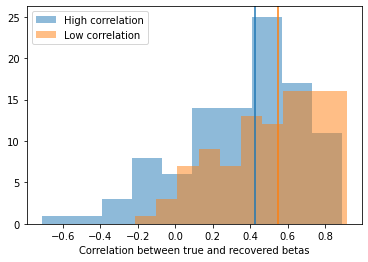

In [3]:
plt.hist(out, label='High correlation', alpha=0.5)
plt.hist(out_low_corr, label='Low correlation', alpha=0.5)
plt.axvline(np.median(out), color='tab:blue')
plt.axvline(np.median(out_low_corr), color='tab:orange')
plt.legend()
plt.xlabel('Correlation between true and recovered betas')

## Medium dataset

With 2000 observations

In [4]:
n_sims = 100

out = []

for i in tqdm(range(n_sims)):
    mean_corr = 0
    while mean_corr < 0.45:
        df, betas, max_corr, mean_corr = simulate_data(2000, 10, noise=5)
    mod = smf.ols(formula='y ~ ' + ' '.join(['+ {0}'.format(i) for i in df.columns if 'x' in i])[2:], data=df)
    res = mod.fit()
    out.append(np.corrcoef(betas[:, 0], res.params[1:])[0, 1])
    
out_low_corr = []

for i in tqdm(range(n_sims)):
    mean_corr = 0
    while mean_corr < 0.1:
        df, betas, max_corr, mean_corr = simulate_data(2000, 10, noise=5)
    mod = smf.ols(formula='y ~ ' + ' '.join(['+ {0}'.format(i) for i in df.columns if 'x' in i])[2:], data=df)
    res = mod.fit()
    out_low_corr.append(np.corrcoef(betas[:, 0], res.params[1:])[0, 1])

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.19it/s]


Text(0.5, 0, 'Correlation between true and recovered betas')

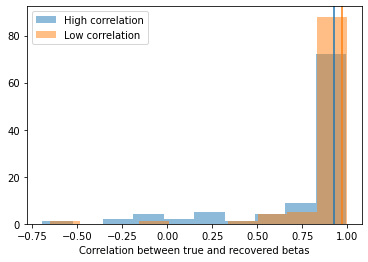

In [5]:
plt.hist(out, label='High correlation', alpha=0.5)
plt.hist(out_low_corr, label='Low correlation', alpha=0.5)
plt.axvline(np.median(out), color='tab:blue')
plt.axvline(np.median(out_low_corr), color='tab:orange')
plt.legend()
plt.xlabel('Correlation between true and recovered betas')

## Large dataset

Comprising 20k observations. In the RSA analyses, because we are looking for relationships between similarity matrices across almost 600 trials, we have a little over 80k observations in each GLM. This simulation therefore represents the most similar case to our analyses.

In [6]:
n_sims = 100

out = []

for i in tqdm(range(n_sims)):
    mean_corr = 0
    while mean_corr < 0.45:
        df, betas, max_corr, mean_corr = simulate_data(20000, 10, noise=5)
    mod = smf.ols(formula='y ~ ' + ' '.join(['+ {0}'.format(i) for i in df.columns if 'x' in i])[2:], data=df)
    res = mod.fit()
    out.append(np.corrcoef(betas[:, 0], res.params[1:])[0, 1])
    
out_low_corr = []

for i in tqdm(range(n_sims)):
    mean_corr = 0
    while mean_corr < 0.1:
        df, betas, max_corr, mean_corr = simulate_data(20000, 10, noise=5)
    mod = smf.ols(formula='y ~ ' + ' '.join(['+ {0}'.format(i) for i in df.columns if 'x' in i])[2:], data=df)
    res = mod.fit()
    out_low_corr.append(np.corrcoef(betas[:, 0], res.params[1:])[0, 1])

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.61it/s]


Text(0.5, 0, 'Correlation between true and recovered betas')

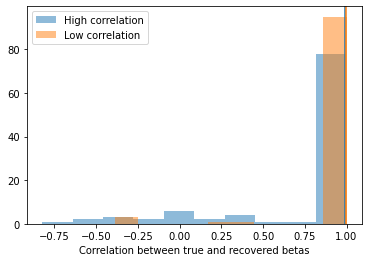

In [7]:
plt.hist(out, label='High correlation', alpha=0.5)
plt.hist(out_low_corr, label='Low correlation', alpha=0.5)
plt.axvline(np.median(out), color='tab:blue')
plt.axvline(np.median(out_low_corr), color='tab:orange')
plt.legend()
plt.xlabel('Correlation between true and recovered betas')

In [8]:
np.median(out)

0.9913132259300814

In [9]:
np.median(out_low_corr)

0.9969166384348507